# MONTE CARLO SIMULATION OF LIGHT-TISSUE INTERACTION: EFFECT OF MELANIN ON LIGHT ABSORPTION

Epidermis is the outermost layer of the skin and it acts as the physical and chemical barrier between the interior body and the exterior environment. It primarily consists of keratinocytes, melanocytes, Langerhans cells, and Markel cells. Melanocytes produce melanin- a natural pigment responsible for the color of our skin, hair, and eyes. Due to its light absorbing characteristics, melanin acts as a photoprotective substance of the human skin. Through a process called melanogenesis, melanin protects our skin by absorbing and reradiating harmful UV radiation and reduces the chance of melanoma.

<img src="images/Epidermis.jpg" width="400" />

In this project, I wish to simulate the light absorbing characteristics of melanin. However, modeling the light-tissue interaction in a turbid media like epidermal tissue using conventional deterministic method is difficult because of the inherent stochasticity of the process [1]. When light is incident on the tissue surface, it can randomly be reflected from the surface or refracted into the tissue. Light that finally enters the tissue are scattered randomly within the tissue. Some light may transmit through the tissue, some are reflected into incident medium while some are absorbed by the tissue.

<img src="images/LightInTissue.png" width="400" />

Due to this stochastic nature of light-tissue interaction, I will use Monte Carlo method for simulating the light absorbing behavior of melanin. Monte Carlo method is a computational technique, invented by Stanislaw Ulam in 1946, that uses repeated random sampling to estimate some functions of probability distribution. I will be using the random walk variant of the Monte Carlo method which relies on taking repeated random steps through a space.

## Random Walk of Photon in Tissue

The random walk of light in epidermis follows the flowchart below. 

<img src="images/BlockDiagram.png" width="700" />

A narrow-collimated photon is launched into the tissue and initially it is directed downwards. A random step size is then calculated using, and a check is done to see whether the photon hits the boundary or not. If the photon hits any of the top or bottom boundary, necessary adjustments to the step are made, and the photon is either reflected into the tissue or transmitted to the top or bottom medium. If the photon transmits to other medium, it is terminated. Otherwise, the photon is moved within the tissue. At the new position, a fraction of the photon energy is absorbed by the tissue and the photon is scattered in random direction. A random step size is calculated again and the photon wanders around the tissue in this manner until its energy has been fully absorbed. In that case, the photon is assumed to be dead and is terminated. The next photon is then launched. [2]

I have implemented each step of the random walk in separate functions and then aggregated them in a single *RandomWalk* function. You will find these functions in their respective scripts in the **functions** directory of this repository. Each function is accompanied with a docstring, describing the function definition, input and output arguments.

This notebook will walk you through the simulation. For avoiding verbosity, I have omitted the comments and docstrings in this notebook. The simulation can also be run just by executing [Melanin.py](Melanin.py) script.

### Import Necessary Libararies

In [1]:
from random import seed
from random import random
from math import floor
from math import copysign
from math import sqrt
from math import log
from math import pi
from math import sin
from math import cos
from math import tan
from math import asin
from math import acos

import numpy as np

from tabulate import tabulate
from matplotlib import pyplot as plt

### Launching Photon Into the Tissue

In [2]:
def LaunchPhoton():
    
    w = 1.0
    
    x = 0.0
    y = 0.0
    z = 0.0
    
    dpx = 0.0
    dpy = 0.0
    dpz = 1.0
    
    return w, x, y, z, dpx, dpy, dpz

### Generate a Random Step Size

In [3]:
def RandomStep(mu_att):
    
    s = - log(random()) / mu_att
    
    return s

### Checking Whether the Photon Hits the Boundary or Not

In [4]:
def BoundaryCheck(w, x, y, z, dpx, dpy, dpz, s, dDR, dDT, d, n_t, n_m, alpha_critical, epsilon = 1e-9):
    
    while True:
        
        if dpz < 0:
            sbound = (0 - z) / dpz
        elif dpz > 0:
            sbound = (d - z) / dpz
        else:
            break
        
        if sbound > s:
            break
        else:
            x += sbound * dpx
            y += sbound * dpy
            z += sbound * dpz
            
            s -= sbound
            
            alpha_i = acos(abs(dpz))
            
            if n_t > n_m:
                if alpha_i > alpha_critical:
                    dpz = - dpz
                    break
            else:
                alpha_t = asin(n_t * sin(alpha_i) / n_m)
                
                R = 0.5 * ((sin(alpha_i - alpha_t))**2 / ((sin(alpha_i + alpha_t))**2 + epsilon) + (tan(alpha_i - alpha_t))**2 / ((tan(alpha_i + alpha_t))**2 + epsilon))
                
                if R < random():
                    if dpz < 0:
                        dDR += w
                    else:
                        dDT += w
                    
                    w = 0
                
                dpz = - dpz
    
    return w, x, y, z, dpx, dpy, dpz, s, dDR, dDT

### Taking a Step

In [5]:
def TakeStep(x, y, z, dpx, dpy, dpz, s):
    
    x += s * dpx
    y += s * dpy
    z += s * dpz
    
    return x, y, z

### Absorbing Photon

In [6]:
def AbsorbPhoton(w, z, pDW, absFact, dz):
    
    dw = w * absFact
    
    if (w - dw) < 0:
        dw = w
    w -= dw
    
    nz = floor(z / dz)
    pDW[nz] += dw
    
    return w, pDW

### Scattering Photon

In [7]:
def ScatterPhoton(dpx, dpy, dpz, g): 
    
    if g == 0:
        theta = acos(2 * random() - 1)
    else:
        theta = acos((1 + g**2 - ((1 - g**2) / (1 - g + 2 * g * random()))**2) / (2 * g))
    
    psi = 2 * pi * random()
    
    
    if abs(dpz) > 0.9999:
        dpx = sin(theta) * cos(psi)
        dpy = sin(theta) * sin(psi)
        dpz = copysign(cos(theta), dpz)
    else:
        dpx = sin(theta) * (dpx * dpz * cos(psi) - dpy * sin(psi)) / sqrt(1 - dpz**2) + dpx * cos(theta)
        dpy = sin(theta) * (dpy * dpz * cos(psi) - dpx * sin(psi)) / sqrt(1 - dpz**2) + dpy * cos(theta)
        dpz = -sin(theta) * cos(psi) * sqrt(1 - dpz**2) + dpz * cos(theta)
    
    return dpx, dpy, dpz

### Aggregate the Functions Together to Take a Random Walk!

In [8]:
def RandomWalk(mu_att, absFact, g, n_t, n_m, alpha_critical, d, dz, dDR, dDT, pDW):   
    
    w, x, y, z, dpx, dpy, dpz = LaunchPhoton()
    
    while True:
        s = RandomStep(mu_att)
        w, x, y, z, dpx, dpy, dpz, s, dDR, dDT = BoundaryCheck(w, x, y, z, dpx, dpy, dpz, s, dDR, dDT, d, n_t, n_m, alpha_critical)
        
        if w <= 0:
            break
        
        x, y, z = TakeStep(x, y, z, dpx, dpy, dpz, s)
        w, pDW = AbsorbPhoton(w, z, pDW, absFact, dz)
        
        if w <= 0:
            break
        
        dpx, dpy, dpz = ScatterPhoton(dpx, dpy, dpz, g)
    
    return dDR, dDT, pDW

## Effect of Melanin Concentration

Let's first simulate the effect of melanin concentration on light absorption. I considere an in vitro setup where the epidermis is covered in a pair of coverslips.

<img src="images/Setup.png" width="400" />

The thickness of the tissue $d$ is $100 \mu m$. For $550 nm$ light, the scattering coefficient $\mu_s$, refractive index $n_t$, and anisotropy of scatter $g$ for epidermis is $74.7 cm^{-1}$, $1.447$, and $0.759$, respectively. The refractive index of the coverslip is $1.5$. The melanin concentration has been divided into three levels- light, medium, and high, corresponding to $1.3-6.3\%$, $11-16\%$, and $18-43\%$ volume fraction of epidermis occupied by melanin, respectively. Their corresponding absorption coefficient $\mu_a$ is given in table below. [3]

|Melanin Concentration|Light | Medium | High  |
|---------------------|------|--------|-------|
|$\mu_a (cm^{-1})$    |$1.63$|$6.85$  |$16.13$|


For each level of melanin concentration, 5 million photons will be launched into the epidermis and the following metrics will be scored-
- how much photon energy have escaped from the boundary of the tissue where the light was incident (diffuse reflectance)
- how much photon energy have escaped from the opposite boundary (diffuse transmittance)
- how much photon energy have been absorbed at various depths (absorption).



Melanin Level      Diffuse Transmittance    Diffuse Reflectance    Absorption
---------------  -----------------------  ---------------------  ------------
Low                             0.388032              0.332539       0.279429
Medium                          0.159724              0.157917       0.682359
High                            0.042999              0.0681065      0.888894




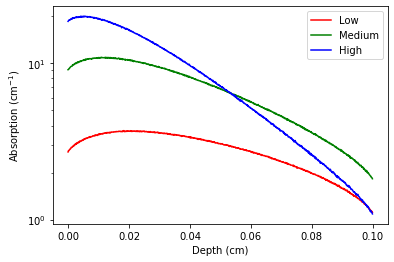

In [9]:
sMelaninLevel = ['Low', 'Medium', 'High']
mu_as = np.array([1.63, 6.85, 16.13])
mu_s = 74.7
g = 0.759
n_t = 1.447
n_m = 1.5
d = 0.1

mu_atts = mu_as + mu_s
absFacts = mu_as / mu_atts

if n_t > n_m:
        alpha_critical = asin(n_m / n_t)
else:
    alpha_critical = float('nan')

N_bins = int(1e3)
dz = d / N_bins

pDW = np.zeros((3, N_bins))
dDR = np.zeros(3)
dDT = np.zeros(3)

N_photons = int(5e6)

for n, (mu_att, absFact) in enumerate(zip(mu_atts, absFacts)):
    for nph in range(N_photons):
        dDR[n], dDT[n], pDW[n] = RandomWalk(mu_att, absFact, g, n_t, n_m, alpha_critical, d, dz, dDR[n], dDT[n], pDW[n])


dDR /= N_photons
dDT /= N_photons
dDW = np.sum(pDW, axis = 1) / N_photons

print('\n')
print(tabulate({'Melanin Level': sMelaninLevel, 'Diffuse Transmittance': dDT, 'Diffuse Reflectance': dDR, 'Absorption': dDW}, headers = 'keys'))
print('\n')

pz = np.arange(0, d, dz)
pDW = pDW / (dz * N_photons)
plt.figure()
plt.semilogy(pz, pDW[0], 'r', label = sMelaninLevel[0])
plt.semilogy(pz, pDW[1], 'g', label = sMelaninLevel[1])
plt.semilogy(pz, pDW[2], 'b', label = sMelaninLevel[2])
plt.xlabel('Depth (cm)')
plt.ylabel('Absorption (cm$^{-1}$)')
plt.legend()

It is evident from the table above that the higher the melanin concentration, the higher the light absorption. The plot demonstrate the depth profile of absorption in the epidermis. Absorption rate is higher near the surface, and it drops off as we go down the epidermis. The rate drops off more quickly for highly pigmented epidermis than medium and lightly pigmented one. 

## Effect of Wavelength

Next, I will demonstrated the wavelength dependency of light absorption by melanin. I have only considered lightly pigmented epidermis for this part. The wavelengths of light $\lambda$ being used, and the corresponding optical properties of epidermis are given in the table below. All the other parameters have the same value as stated above. [3]

|$\lambda (nm)$|$\mu_a (cm^{-1})$|$\mu_s (cm^{-1})$|$g$  |$n_t$|
|--------------|-----------------|-----------------|-----|-----|
|350           |30.16            |210.4            |0.702|1.488|
|450           |13.5             |121.6            |0.728|1.448|
|550           |6.85             |74.7             |0.759|1.447|
|650           |3.68             |55.48            |0.787|1.433|

For each wavelength of light, 5 million photons have been launched into the epidermis and their absorption depth profile has been recorded. 



  Wavelengths    Diffuse Transmittance    Diffuse Reflectance    Absorption
-------------  -----------------------  ---------------------  ------------
          350              0.000318329               0.129227      0.870455
          450              0.024086                  0.150934      0.82498
          550              0.159541                  0.15793       0.682529
          650              0.362692                  0.166306      0.471001




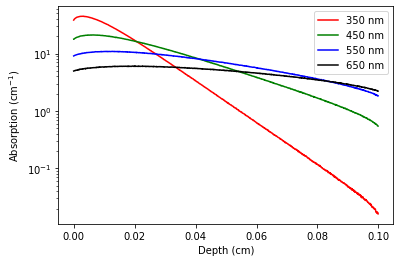

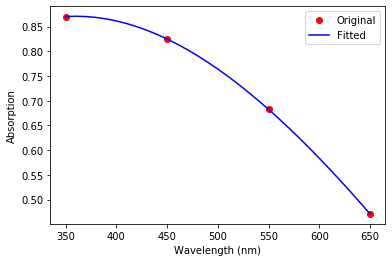

In [10]:
nWavelengths = np.array([350, 450, 550, 650])
mu_as = np.array([30.16, 13.5, 6.85, 3.68])
mu_ss = np.array([210.4, 121.6, 74.7, 55.48])
gs = np.array([0.702, 0.728, 0.759, 0.787])
n_ts = np.array([1.488, 1.448, 1.447, 1.433])
n_m = 1.5
d = 0.1

mu_atts = mu_as + mu_ss
absFacts = mu_as / mu_atts

alpha_criticals = np.zeros(4)
for n, n_t in enumerate(n_ts):
    if n_t > n_m:
            alpha_criticals[n] = asin(n_m / n_t)
    else:
        alpha_criticals[n] = float('nan')

N_bins = int(1e3)
dz = d / N_bins

pDW = np.zeros((4, N_bins))
dDR = np.zeros(4)
dDT = np.zeros(4)

N_photons = int(5e6)

for n, (mu_att, absFact, g, n_t, alpha_critical) in enumerate(zip(mu_atts, absFacts, gs, n_ts, alpha_criticals)):
    for nph in range(N_photons):
        dDR[n], dDT[n], pDW[n] = RandomWalk(mu_att, absFact, g, n_t, n_m, alpha_critical, d, dz, dDR[n], dDT[n], pDW[n])

        
dDR /= N_photons
dDT /= N_photons
dDW = np.sum(pDW, axis = 1) / N_photons

print('\n')
print(tabulate({'Wavelengths': nWavelengths, 'Diffuse Transmittance': dDT, 'Diffuse Reflectance': dDR, 'Absorption': dDW}, headers = 'keys'))
print('\n')

pz = np.arange(0, d, dz)
pDW = pDW / (dz * N_photons)
plt.figure()
plt.semilogy(pz, pDW[0], 'r', label = str(nWavelengths[0]) + ' nm')
plt.semilogy(pz, pDW[1], 'g', label = str(nWavelengths[1]) + ' nm')
plt.semilogy(pz, pDW[2], 'b', label = str(nWavelengths[2]) + ' nm')
plt.semilogy(pz, pDW[3], 'k', label = str(nWavelengths[3]) + ' nm')
plt.xlabel('Depth (cm)')
plt.ylabel('Absorption (cm$^{-1}$)')
plt.legend()

p = np.polyfit(nWavelengths, dDW, 3)
nWaves = np.arange(350, 660, 10)
fitted = np.polyval(p, nWaves)
plt.figure()
plt.plot(nWavelengths, dDW, 'ro', label = 'Original')
plt.plot(nWaves, fitted, 'b', label = 'Fitted')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption')
plt.legend()

From the above table and plots, it is evident that the lower the wavelength, the higher the light absorption. The depth profile demonstrate that the absorption rate drops off more quickly for the lower wavelengths of light than the higher wavelengths.

### References

1. Zhu, C. and Liu, Q., 2013. Review of Monte Carlo modeling of light transport in tissues. Journal of biomedical optics, 18(5), p.050902.
2. Wang, L., Jacques, S.L. and Zheng, L., 1995. MCML—Monte Carlo modeling of light transport in multi-layered tissues. Computer methods and programs in biomedicine, 47(2), pp.131-146.
3. Bashkatov, A.N., Genina, E.A. and Tuchin, V.V., 2011. Optical properties of skin, subcutaneous, and muscle tissues: a review. Journal of Innovative Optical Health Sciences, 4(01), pp.9-38.